# PyTorch Workflow

Let's explore an example fo PyTorch end-to-end workflow.

In [10]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to the data (training)",
                      4: "making predictions and evaluating a model (inference)",
                      5: "saving and loading a model",
                      6: "putting it all together"}

In [11]:
import torch
from torch import nn # nn c`ontains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.1'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.
* Excel  spreadsheet
* Images of any kind
* Videos (YT has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**

In [12]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [13]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and test set with our data.

In [14]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [15]:
# Use Scikit-Learn to create a random train/test split (this is the preferred way)
import sklearn.model_selection as skm
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, train_size=0.8, test_size=0.2)

How might we better visualize the data?
"Visualize, visualize, visualize!"

In [16]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions=None):
    """
    plots trianing data, test data and compares predictions
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", label="Testing data")
    
    # Are there any predictions?
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14});

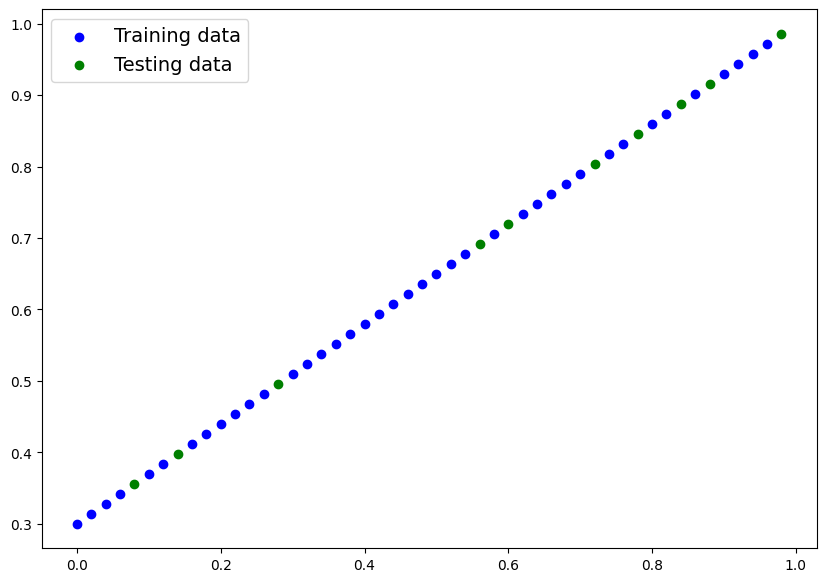

In [17]:
plot_predictions()

## 2. Building model

Our first PyTorch model!

This is very exciting... let's do it!

Because we're going to be building classes throughout the course, 
I'd recommend getting familiar with OOP in Python

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the rnadom values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through 2 main algorithms
1. Gradient descent (why we require "grad = True" argument)
2. Backpropagation

In [18]:
from torch import nn

# Creat linear regression model class: 2 parameters (1 weight, bias)
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()

        # Initialize model parameters
        self.weights = nn.Parameter(torch.randn(1,      # <- start with a random weight and try to adjust it to the ideal weight
                                                requires_grad=True, # <- can this parameter be updated with gradient descent?
                                                dtype=torch.float)) # Pytorch loves dtype float32
        self.bias = nn.Parameter(torch.randn(1,         # <- start with a random bias and try to adjust it to the ideal bias
                                             requires_grad=True,
                                             dtype=torch.float))
    # Foward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
        return self.weights * x + self.bias # this is the linear regression formula

### Pytorch model building essentials
* torch.nn - contains all of the buildings for computational graphs (neural networks can be considered computational graphs)
* torch.nn.Parameter - what parameters (weights and biases) are updated during training. Often a Pytorch layer from torch.nn will set these for us.
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

Some more are found in the pytorch cheatsheet: https://pytorch.org/tutorials/beginner/ptcheat.html

In [19]:
# Checking the contents of our PyTorch model

# Create random seed
torch.manual_seed(42)

# Create an instance of our model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check model parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [20]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` from `X_test`.

When we passed the data through our model, it's going to run it through the forward() method.

In [21]:
# Make a prediction with model (not using inference_mode(), so it keeps track of gradients; slower)
y_preds = model_0(X_test)
y_preds

tensor([[0.3914],
        [0.4251],
        [0.4116],
        [0.3308],
        [0.1557],
        [0.3712],
        [0.2231],
        [0.3174],
        [0.1759],
        [0.4588]], grad_fn=<AddBackward0>)

In [22]:
# Making predictions with model (inference_mode() does not keep track of gradients; it's faster)
with torch.inference_mode():
    y_preds = model_0.forward(X_test)

# You can also do something similar with torch.no_grad() but inference_mode() is preferred
# with torch.no_grad():
#     y_preds = model_0.forward(X_test)

y_preds

tensor([[0.3914],
        [0.4251],
        [0.4116],
        [0.3308],
        [0.1557],
        [0.3712],
        [0.2231],
        [0.3174],
        [0.1759],
        [0.4588]])

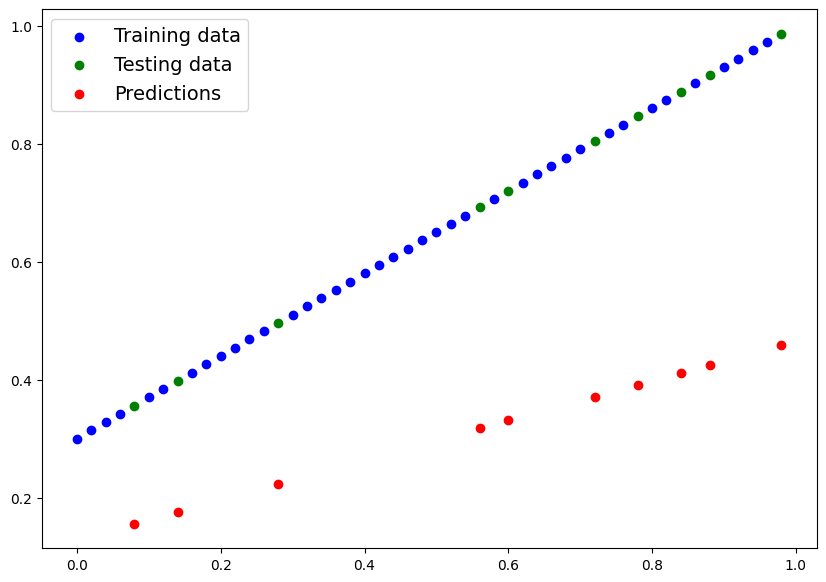

In [23]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training si for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.


Improve model by implementing a loss function. Multiple options in PyTorch.

* Note: Loss function may also be called cost function or criterion in different areas.

Things we need to train:

* **Loss function:** A function to measure how wrong a model's predictions are to the ideal outputs, lower is better. e.g. nn.L1loss()
    1. Regression problems tend to use `nn.L1Loss()` or `nn.MSELoss()` for loss, along with a `torch.optim.SGD()` for optimizer
    2. Classification problems will likely use a `nn.BCELosss()` (binary cross entropy loss).
* **Optimizer:** Takes into acct the loss of a model and adjusts the model's parameters (e.g. weight & bias)
    * `optimizer = torch.optim.SGD(params, lr)` is also an example of creating an instance of a class (in this case the class optim.SGD)
    * Can also use a scheduler for optimizer (optional)

And specifically from PyTorch, we need:
* A training loop
* A testing loop

In [24]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [25]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup optimizer (stoachastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), # <- pass in the parameters of the model we want to train
                            lr = 0.01) # lr = learning rate = possibly the most important hyperparameter you can set

### Buildng a training/testing loop
0. Loop through data
1. Forward pass: produce outputs from parameters
2. Calculate the loss: compare to truth (training)
3. Optimizer zero grad
4. Loss backward (Backpropagation)
    * Take derivative of loss function to determine parameters with largest slopes
5. Optimizer step (Gradient descent)
    * Determines the changes to parameters/step to take to get closer to minimum loss

Testing: evaluates the model

In [26]:
# An epoch is one loop through the data - hyperparameter
epochs = 100

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # keeps the gradients tracking on

    # 1. Forward pass : found in the model_0.forward() method
    y_pred = model_0(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer 0 grad
    optimizer.zero_grad() # <- reset the gradients of the parameters (which come with the parameters) so that the update step doesn't use a combination of old and new gradients

    # 4. Backward pass
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()

    ### Testing: Uses .inference() mode instead of .train() mode
    model_0.eval() # does not turn off gradient tracking; DOES turn off different settings in the model not needed for evaluation/testing (dropout, batchnorm, etc.) 
    with torch.inference_mode(): # turns off gradient tracking & some other things
        # 1. Forward pass
        test_preds = model_0(X_test)

        # 2. Calculate loss
        test_loss = loss_fn(test_preds, y_test)

        # Do not need backpropagation or gradient descent (not trying to improve the model)
        
    # Print out the progress
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

    # Print out model state_dict()
    print(model_0.state_dict())

Epoch: 0 | Train loss: 0.3404929041862488 | Test loss: 0.3713592290878296
OrderedDict([('weights', tensor([0.3414])), ('bias', tensor([0.1388]))])
OrderedDict([('weights', tensor([0.3460])), ('bias', tensor([0.1488]))])
OrderedDict([('weights', tensor([0.3507])), ('bias', tensor([0.1588]))])
OrderedDict([('weights', tensor([0.3553])), ('bias', tensor([0.1688]))])
OrderedDict([('weights', tensor([0.3600])), ('bias', tensor([0.1788]))])
OrderedDict([('weights', tensor([0.3647])), ('bias', tensor([0.1888]))])
OrderedDict([('weights', tensor([0.3693])), ('bias', tensor([0.1988]))])
OrderedDict([('weights', tensor([0.3740])), ('bias', tensor([0.2088]))])
OrderedDict([('weights', tensor([0.3786])), ('bias', tensor([0.2188]))])
OrderedDict([('weights', tensor([0.3833])), ('bias', tensor([0.2288]))])
Epoch: 10 | Train loss: 0.21877717971801758 | Test loss: 0.24405154585838318
OrderedDict([('weights', tensor([0.3880])), ('bias', tensor([0.2388]))])
OrderedDict([('weights', tensor([0.3926])), ('

In [27]:
# output parameters after 100 epochs
model_0.state_dict()

OrderedDict([('weights', tensor([0.6185])), ('bias', tensor([0.3393]))])

In [28]:
# how to convert loss values from tensor to numpy: torch.tensor(loss_values).numpy()
print(f"loss_values is a list of tensors: {loss_values[:2]}")
print(f"convert it into a single tensor: torch.tensor(loss_values)[:2] = {torch.tensor(loss_values)[:2]}")
print(f"convert it into a numpy array: torch.tensor(loss_values).numpy()[:2] = {torch.tensor(loss_values).numpy()[:2]}")

loss_values is a list of tensors: [tensor(0.3405, grad_fn=<MeanBackward0>), tensor(0.2188, grad_fn=<MeanBackward0>)]
convert it into a single tensor: torch.tensor(loss_values)[:2] = tensor([0.3405, 0.2188])
convert it into a numpy array: torch.tensor(loss_values).numpy()[:2] = [0.3404929  0.21877718]


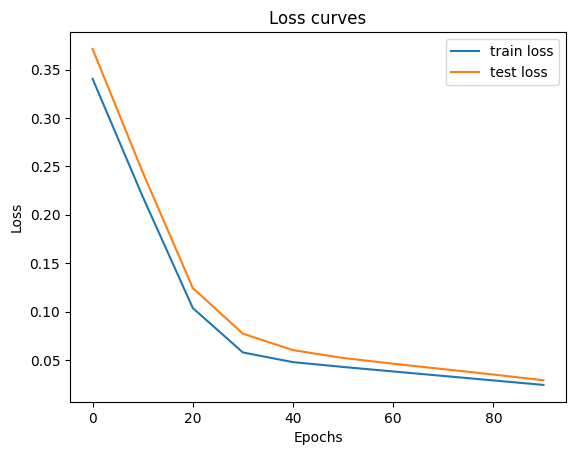

In [29]:
# plot the loss curves
import numpy as np
plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label="train loss") # need to change loss_values to numpy and not tensor
plt.plot(epoch_count, torch.tensor(test_loss_values).numpy(), label="test loss") # same here

plt.title("Loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [30]:
with torch.inference_mode():
    y_preds_new = model_0.forward(X_test)

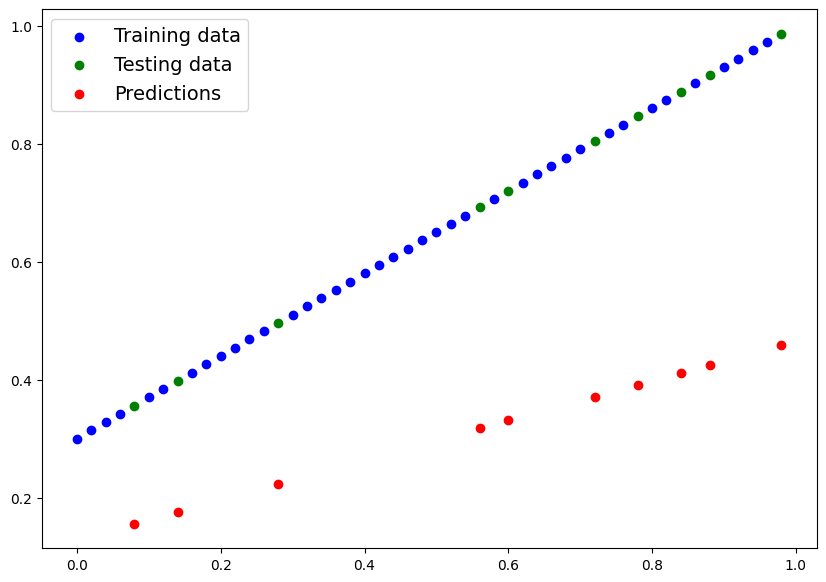

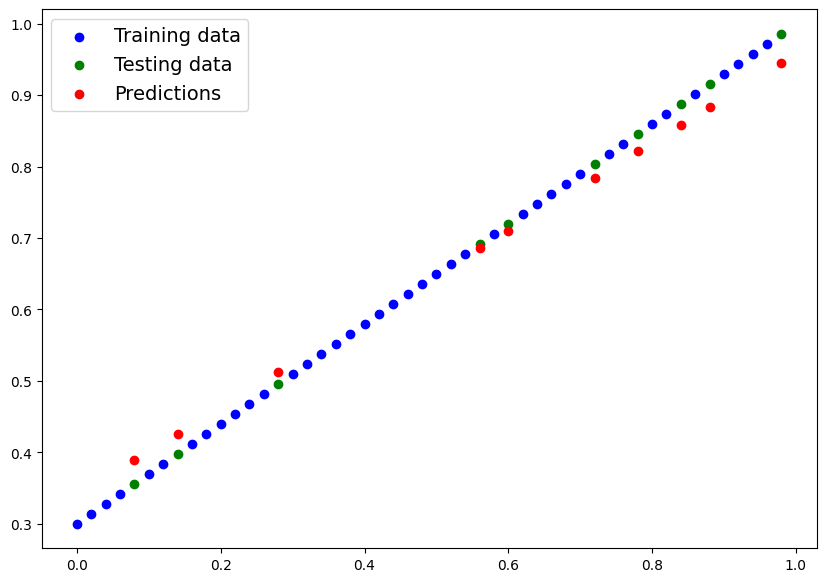

In [31]:
plot_predictions(predictions=y_preds)
plot_predictions(predictions=y_preds_new)

## Saving and Loading a model
Documentation: https://pytorch.org/tutorials/beginner/saving_loading_models.html

## 4. Saving a model in PyTorch

3 main methods for this.

1. `torch.save()` - saves PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows you to load the model's saved state dictionary

In [32]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME ="01_workflow_model_0.pth" # convention to sve PyTorch models with .pth extension
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME # syntax for Pathlib Path

# 3. Save model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), 
           f=MODEL_SAVE_PATH)

Saving model to: models/01_workflow_model_0.pth


In [33]:
!ls -l models # should say etc...@ 1 amyfan ...etc.

total 16
-rw-r--r--@ 1 amyfan  staff  1568 Dec 10 01:04 01_workflow_model_0.pth
-rw-r--r--@ 1 amyfan  staff  1632 Dec  9 23:25 01_workflow_model_1.pth


## 5. Loading a model in PyTorch

Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the state_dict() into that.

In [34]:
# Need to load the state dict into something: instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load saved state_dict into this model
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [35]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6185])), ('bias', tensor([0.3393]))])

In [36]:
# Make some predictions with our loaded model
loaded_model_0.eval() 
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
    # y_preds = model_0(X_test) # run to get correct y_preds values, y_preds got saved somewhere else from previous lines of code.

loaded_model_preds

tensor([[0.8218],
        [0.8836],
        [0.8589],
        [0.7104],
        [0.3888],
        [0.7846],
        [0.5125],
        [0.6857],
        [0.4259],
        [0.9455]])

In [37]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds # True once you run the commented out code from previous block.

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])

## 6. Putting it all together
Go through it all in one place

In [38]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# check PyTorch version
torch.__version__

'2.1.1'

In [39]:
# Create device agnostic code (works on CPU and GPU)
from functions import get_device
device = get_device()

### 6.1 Data

In [40]:
# Create data using linear equation
weight = 0.7
bias = 0.3

# Create range of values
start = 0
end = 1
step = 0.02
scale = 15

# Create X & y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # unsqueeze adds an extra dimension to the tensor; you need this
epsilon = torch.randn(X.shape) / scale # add some noise to the data
y = weight * X + bias + epsilon
X[:5], y[:5] 

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.4192],
         [0.2821],
         [0.3118],
         [0.2797],
         [0.3394]]))

In [41]:
# Split the data
import sklearn.model_selection as skm
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, train_size=0.8, test_size=0.2)

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

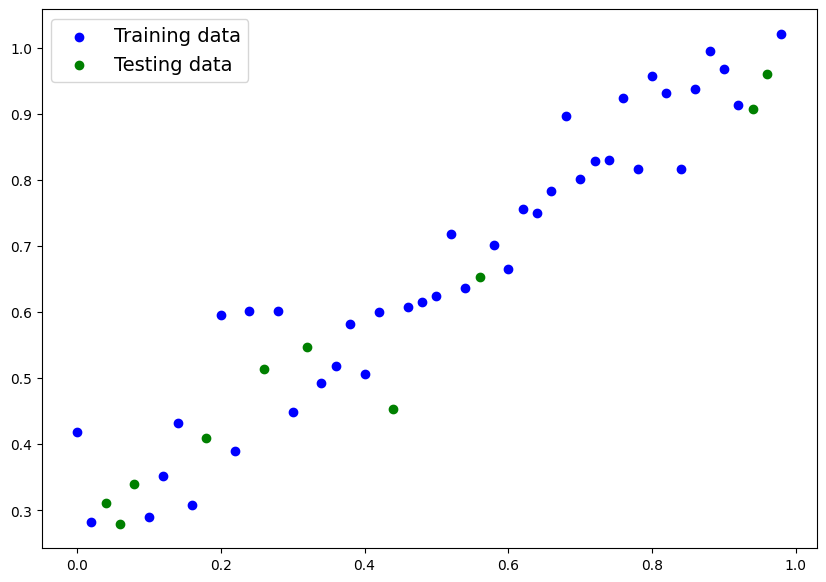

In [42]:
# plot data
plot_predictions(train_data=X_train,test_data=X_test,train_labels=y_train,test_labels=y_test)

### 6.2 Building a PyTorch Linear model
Using nn.Linear to automate build layers (multiple options: https://pytorch.org/docs/stable/nn.html)

In [43]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters instead of manually / also  called: linear transform, probing layer, fully connected layer, dense layer
        self.linear_layer = nn.Linear(in_features = 1, # one x ...
                                      out_features=1)  # ... corresponds to one y (one-to-one)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [44]:
# Check the model current device
next(model_1.parameters()).device # device is the 1-index in parameters

device(type='cpu')

In [48]:
# Set the model to the target device
model_1 = model_1.to(device)
next(model_1.parameters()).device

# And all data to the same device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

### 6.3 Training/Testing

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [46]:
# Setup loss function instance
loss_fn = nn.L1Loss()

# Setup optimizer instance
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.01)

In [49]:
 # Let's write a training/testing loop
torch.manual_seed(42)

epochs = 200

# Get ready to save 
loss_values = []
test_loss_values = []

# 0. loop through data
for epoch in range(epochs):
    model_1.train()
    
    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Loss calculation
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer 0 grad
    optimizer.zero_grad()

    # 4. Backward pass (Backprop)
    loss.backward()

    # 5. Optimizer step (Gradient Descent)
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_preds = model_1(X_test)
        test_loss = loss_fn(test_preds,y_test)

    # Save the loss values
    loss_values.append(loss.item())
    test_loss_values.append(test_loss.item())

    # Print out the progress        
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")


/Users/amyfan/Desktop/pytorch-walkthrough/.venv/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 | Loss: 0.5521613359451294 | Test loss: 0.5741094946861267
Epoch: 50 | Loss: 0.06748350709676743 | Test loss: 0.0882917270064354
Epoch: 100 | Loss: 0.06183285638689995 | Test loss: 0.06468695402145386
Epoch: 150 | Loss: 0.05710190534591675 | Test loss: 0.05242800712585449


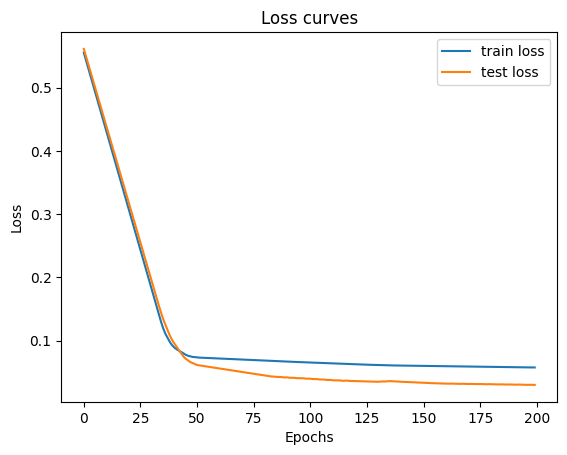

In [280]:
# Plot the loss curves
plt.plot(loss_values, label="train loss")
plt.plot(test_loss_values, label="test loss")

plt.title("Loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [281]:
# Make predictions with our trained model
model_1.eval()
with torch.inference_mode():
    y_preds = model_1(X_test)

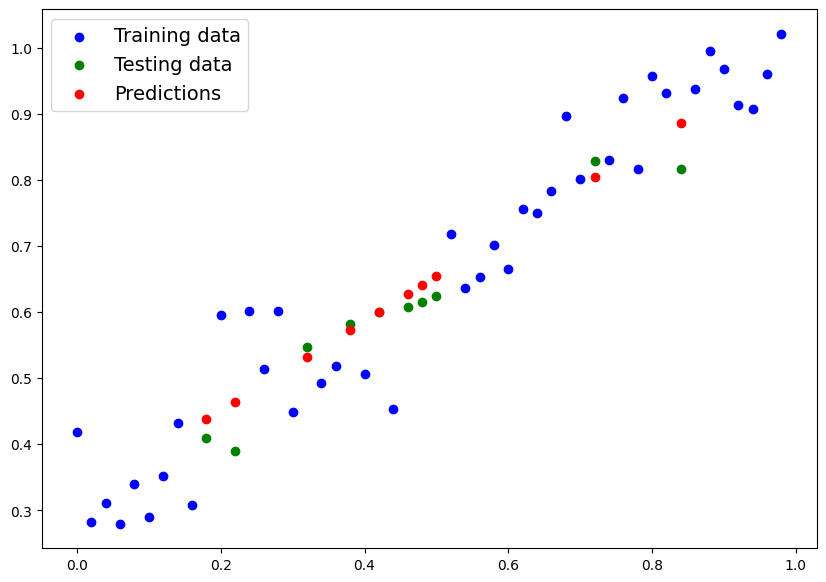

In [282]:
plot_predictions(train_data=X_train.cpu(), test_data=X_test.cpu(), train_labels=y_train.cpu(), test_labels=y_test.cpu(), predictions=y_preds.cpu())

### 6.4/5 Saving and loading a model

In [284]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents = True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_workflow_model_1.pth"
MODEL_SAVE_NAME = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_NAME}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_NAME)


Saving model to: models/01_workflow_model_1.pth


In [285]:
# Instantiate a model
loaded_model_1 = LinearRegressionModelV2()

# Load in the state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_NAME))

# Put model to device
loaded_model_1 = loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [291]:
next(loaded_model_1.parameters()).device

<generator object Module.parameters at 0x29b524d60>

In [293]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')